**PRE PROCESSING**

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# unisco tutti i dataset all'interno delle cartelle, in un unico dataframe
paths = list(Path(r'C:\Users\dsalvatorelli\Desktop\Group project_ML\Data').rglob('*.*'))

## Features path
co2_paths = [path for path in paths if path.name == 'co2.csv']
humidity_paths = [path for path in paths if path.name == 'humidity.csv']
temperature_paths = [path for path in paths if path.name == 'temperature.csv']
light_paths = [path for path in paths if path.name == 'light.csv']


## Target path
pir_paths = [path for path in paths if path.name == 'pir.csv']

frames = []
for light_path, temperature_path, co2_path, pir_path, humidity_path in zip(light_paths, temperature_paths, co2_paths, pir_paths, humidity_paths):
    
    ## Features
    light_df = pd.read_csv(light_path, names=['unix_time', 'light'], index_col='unix_time')
    temperature_df = pd.read_csv(temperature_path, names=['unix_time', 'temperature'], index_col='unix_time')
    co2_df = pd.read_csv(co2_path, names=['unix_time', 'co2'], index_col='unix_time')
    humidity_df = pd.read_csv(humidity_path, names=['unix_time', 'humidity'], index_col='unix_time')
    
    ##Target
    pir_df = pd.read_csv(pir_path, names=['unix_time', 'pir'], index_col='unix_time')
    
    ##Adding into single label
    df = pd.concat([light_df, temperature_df, co2_df, pir_df, humidity_df], axis=1)
    df['room'] = light_path.parent.name
    frames.append(df)
    
data = pd.concat(frames)

In [13]:
data.head()

,light,temperature,co2,pir,humidity,room
unix_time,,,,,,
1377299107,97.0,23.93,488.0,NaN,45.34,413
1377299108,97.0,23.94,495.0,0.0,45.34,413
1377299110,NaN,NaN,487.0,NaN,NaN,413
1377299126,97.0,23.93,NaN,0.0,45.34,413
1377299127,NaN,NaN,496.0,0.0,NaN,413


In [3]:
data.describe()

,light,temperature,co2,pir,humidity
count,6.571463e+06,6.571505e+06,6.574008e+06,3.593953e+06,6.571465e+06
mean,8.226156e+01,2.397020e+01,4.110066e+02,1.754301e+00,5.674771e+01
std,3.101547e+02,2.119168e+01,1.035154e+02,1.934540e+01,4.307900e+00
min,0.000000e+00,-4.010000e+01,8.000000e+00,0.000000e+00,-5.009600e+02
25%,3.000000e+00,2.253000e+01,3.520000e+02,0.000000e+00,5.398000e+01
50%,5.000000e+00,2.311000e+01,4.100000e+02,0.000000e+00,5.701000e+01
75%,3.000000e+01,2.371000e+01,4.630000e+02,0.000000e+00,5.974000e+01
max,3.055100e+04,5.792700e+02,1.699000e+03,3.445600e+04,7.191000e+01


In [4]:
data.isnull().sum() / len(data)

light          0.543066
temperature    0.543063
co2            0.542889
pir            0.750101
humidity       0.543066
room           0.000000
dtype: float64

In [5]:
data.shape

(14381639, 6)

In [6]:
#sostituisco i valori nulli di light, temperature,co2 e umidità con il valore medio tra il valore precedente non nullo e successivo non nullo
columns=['light','temperature','co2','humidity']
for column in columns:
    data[[column]] = (data[[column]].ffill()+data[[column]].bfill())/2
    data[[column]]= data[[column]].bfill().ffill()

In [7]:
data.head()

,light,temperature,co2,pir,humidity,room
unix_time,,,,,,
1377299107,97.0,23.930,488.0,NaN,45.340,413
1377299108,97.0,23.940,495.0,0.0,45.340,413
1377299110,97.0,23.935,487.0,NaN,45.340,413
1377299126,97.0,23.930,491.5,0.0,45.340,413
1377299127,97.0,23.930,496.0,0.0,45.325,413


In [8]:
data.isnull().sum() / len(data)

light          0.000000
temperature    0.000000
co2            0.000000
pir            0.750101
humidity       0.000000
room           0.000000
dtype: float64

**SCORING DATASET**

In [23]:
#seleziono le righe con valore di pir NULLO, creo un dataset e lo esporto in csv
data_s1scor = data.copy()
data_s1scor= data_s1scor[data_s1scor['pir'].isnull()]
data_s1scor.reset_index(drop=True, inplace=True)
data_s1scor.drop(columns=['pir',], inplace=True)
data_s1scor.head()

,light,temperature,co2,humidity,room
0,97.0,23.930,488.0,45.340,413
1,97.0,23.935,487.0,45.340,413
2,97.0,23.930,497.5,45.310,413
3,97.0,23.925,500.0,45.325,413
4,97.0,23.920,497.5,45.340,413


In [24]:
data_s1scor.to_csv(r"C:\Users\dsalvatorelli\Desktop\Group project_ML\data_scoring_s1.csv", float_format='%.2f',index=False)

**CLEANED DATASET**

In [9]:
#rimuovo i missing pir
data_s1 = data.copy()
data_s1 = data_s1.dropna(subset=['pir'])

#aggiungo la colonna occupancy [0,1], i.e. la categorizzazione del pir
data_s1['occupancy'] = data_s1['pir'].apply(lambda x: 0 if x == 0 else 1)

#converto room da number a categorical
data_s1['room'] = data_s1.room.astype('category')

#rimuovo le colonne unix time e pir
data_s1.reset_index(drop=True, inplace=True)
data_s1.drop(columns=['pir',], inplace=True)
data_s1.head()


,light,temperature,co2,humidity,room,occupancy
0,97.0,23.94,495.0,45.340,413,0
1,97.0,23.93,491.5,45.340,413,0
2,97.0,23.93,496.0,45.325,413,0
3,97.0,23.93,495.0,45.325,413,0
4,96.5,23.92,495.0,45.340,413,0


In [10]:
data_s1.dtypes

light           float64
temperature     float64
co2             float64
humidity        float64
room           category
occupancy         int64
dtype: object

In [11]:
data_s1['occupancy'].value_counts()/ len(data_s1) 

0    0.928583
1    0.071417
Name: occupancy, dtype: float64

In [12]:
data_s1.shape

(3593953, 6)

In [24]:
data_s1.to_csv(r"C:\Users\dsalvatorelli\Desktop\Group project_ML\data_cleaned_s1.csv", float_format='%.2f',index=False)

**MACHINE LEARNING**

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier  
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import numpy as np

In [2]:
ds = pd.read_csv(r"C:\Users\dsalvatorelli\Desktop\Group project_ML\data_cleaned_s1.csv")
ds.shape

(3593953, 6)

In [5]:
ds.corr()

,light,temperature,co2,humidity,room,occupancy
light,1.000000,-0.002409,-0.040407,0.071356,0.125447,0.126855
temperature,-0.002409,1.000000,0.068884,-0.036678,-0.078550,0.012794
co2,-0.040407,0.068884,1.000000,-0.051390,-0.059377,0.362032
humidity,0.071356,-0.036678,-0.051390,1.000000,-0.096842,-0.080317
room,0.125447,-0.078550,-0.059377,-0.096842,1.000000,0.088118
occupancy,0.126855,0.012794,0.362032,-0.080317,0.088118,1.000000


<AxesSubplot:>

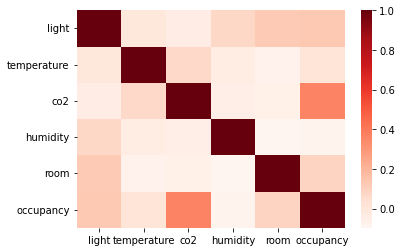

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
correlation = ds.corr()
sns.heatmap(correlation, cmap="Reds")

**Divisione dataset in training = 40 stanze e validation = 11 stanze**

In [27]:
#5 stanze 413,423,424,510,564,552,621,625,717,748,776
ds_val = ds.loc[ds['room'].isin([413,423,424,510,564,552,621,625,717,748,776])]
ds_val.shape

(727991, 6)

In [ ]:
#5 stanze 413,423,424,510,564,552,621,625,717,748,776
ds_val = ds.loc[ds['room'].isin([413,423,424,510,564,552,621,625,717,748,776])]
ds_val.shape

In [28]:
ds_val['occupancy'].value_counts()/ len(ds_val) 

0    0.931043
1    0.068957
Name: occupancy, dtype: float64

In [29]:
ds_train = ds[~ds.room.isin([413,423,424,510,564,552,621,625,717,748,776])]
ds_train.shape

(2865962, 6)

In [30]:
ds_train['occupancy'].value_counts()/ len(ds_train)

0    0.927958
1    0.072042
Name: occupancy, dtype: float64

**OLD**

In [ ]:
count_occupancy_train_0, count_occupancy_train_1 = ds_train.occupancy.value_counts()
count_occupancy_val_0, count_occupancy_val_1 = ds_val.occupancy.value_counts()
   
   data_occupancy_train_0 = ds_train[ds_train['occupancy']==0]
    data_occupancy_train_1 = ds_train[ds_train['occupancy']==1]
    counter_bf = ds_train['occupancy'].value_counts()/ len(ds) 
    data_occupancy_train_1_over = data_occupancy_train_1.sample(count_occupancy_train_0//i, replace = True)
    ds_train_over = pd.concat([data_occupancy_train_0, data_occupancy_train_1_over], axis = 0)

    data_occupancy_val_0 = ds_val[ds_val['occupancy']==0]
    data_occupancy_val_1 = ds_val[ds_val['occupancy']==1]
    data_occupancy_val_1_over = data_occupancy_val_1.sample(count_occupancy_val_0//i, replace = True)
    ds_val_over = pd.concat([data_occupancy_val_0, data_occupancy_val_1_over], axis = 0)


        
    
    y_train= ds_train_over['occupancy']
    X_train = ds_train_over.drop(['occupancy','room'], axis=1) 

    y_test= ds_val_over['occupancy']
    X_test = ds_val_over.drop(['occupancy','room'], axis=1)

    counter_af= ds_val_over['occupancy'].value_counts()/ len(ds_train_over) 


count_occupancy_0, count_occupancy_1 = ds_train.occupancy.value_counts()
data_occupancy_0 = ds_train[ds_train['occupancy']==0]
data_occupancy_1 = ds_train[ds_train['occupancy']==1]
counter_bf = ds_train['occupancy'].value_counts()/ len(ds) 
data_occupancy_1_over = data_occupancy_1.sample(count_occupancy_0//3, replace = True)

ds_train_over = pd.concat([data_occupancy_0, data_occupancy_1_over], axis = 0)

y_train= ds_train_over['occupancy']
X_train = ds_train_over.drop(['occupancy'], axis=1)

y_test= ds_val['occupancy']
X_test = ds_val.drop(['occupancy'], axis=1)

Score = pd.DataFrame()


**Oversampling**

In [7]:
oversample = pd.DataFrame()
ds_over = ds.copy()
count_occupancy_0, count_occupancy_1 = ds_over.occupancy.value_counts()
# oversampling su training e validation

for i in range(1,8):
    data_occupancy_0 = ds_over[ds_over['occupancy']==0]
    data_occupancy_1 = ds_over[ds_over['occupancy']==1]
    data_occupancy_1 = data_occupancy_1.sample(count_occupancy_0//i, replace = True)
    ds_over = pd.concat([data_occupancy_0, data_occupancy_1], axis = 0)

    X = ds_over.drop(['occupancy','room'], axis=1)
    y = ds_over['occupancy']
    
    X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
    # stratified + statistica descrittiva label

    DT = DecisionTreeClassifier(random_state=0)
    start_time = time.time()
    DT.fit(X_train,y_train)
    y_pred_train_DT = DT.predict(X_train)
    y_pred_test_DT = DT.predict(X_test)
    acc_train_DT = accuracy_score(y_train,y_pred_train_DT)
    acc_test_DT = accuracy_score(y_test,y_pred_test_DT)
    f1_score_train_DT = f1_score(y_train, y_pred_train_DT)
    precision_test_DT = precision_score(y_test, y_pred_test_DT)
    recall_test_DT = recall_score(y_test, y_pred_test_DT)
    f1_score_test_DT = f1_score(y_test, y_pred_test_DT)
        
    timez_DT = (time.time() - start_time)

    df_DT = {"Oversampling rate": i,'Train Accuracy': acc_train_DT, 'Test Accuracy': acc_test_DT, 'Train F1': f1_score_train_DT,
    'Test F1': f1_score_test_DT, 'Test Precision': precision_test_DT, 'Test Recall': recall_test_DT,  'Training time [s]': timez_DT}
    oversample = oversample.append(df_DT, ignore_index=True)

oversample.head(15)


,Oversampling rate,Test Accuracy,Test F1,Test Precision,Test Recall,Train Accuracy,Train F1,Training time [s]
0,1.0,0.988882,0.988989,0.980156,0.997981,0.991322,0.991378,67.500233
1,2.0,0.986352,0.979778,0.967721,0.992138,0.989710,0.984689,61.892297
2,3.0,0.985501,0.971397,0.959993,0.983076,0.989651,0.979421,56.281890
3,4.0,0.985570,0.964135,0.958830,0.969498,0.990227,0.975535,48.820719
4,5.0,0.986140,0.958693,0.953382,0.964063,0.990926,0.972717,49.827997
5,6.0,0.986703,0.953803,0.946799,0.960912,0.991638,0.970732,45.829683
6,7.0,0.987397,0.949981,0.940169,0.960000,0.992043,0.968253,44.783894


Text(0.5, 0, 'Oversampling rate')

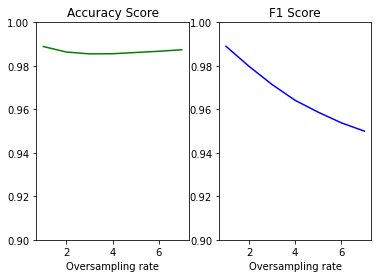

In [8]:
classifierz = oversample['Oversampling rate']
acctes = oversample['Test Accuracy']
f1tes = oversample['Test F1']
precisiontes = oversample['Test Precision']
recalltes = oversample['Test Recall']

plt.subplot(1, 2, 1)
plt.title('Accuracy Score')
plt.plot(classifierz, acctes, 'g')
plt.ylim(0.9,1)
plt.xlabel('Oversampling rate')

plt.subplot(1, 2, 2)
plt.title('F1 Score')
plt.plot(classifierz, f1tes, 'b')
plt.ylim(0.9,1)
plt.xlabel('Oversampling rate')


Text(0.5, 0, 'Oversampling rate')

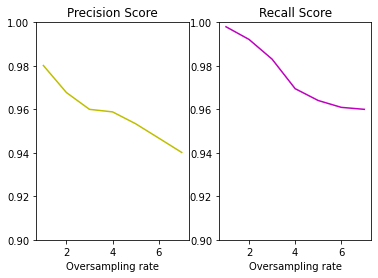

In [9]:
plt.subplot(1, 2, 1)
plt.title('Precision Score')
plt.plot(classifierz, precisiontes, 'y')
plt.ylim(0.9,1)
plt.xlabel('Oversampling rate')

plt.subplot(1, 2, 2)
plt.title('Recall Score')
plt.plot(classifierz, recalltes, 'm')
plt.ylim(0.9,1)
plt.xlabel('Oversampling rate')

**Modeling**

In [3]:
y = ds['occupancy']
X = ds.drop(['occupancy','room'], axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=0)

In [32]:
y_train= ds_train['occupancy']
X_train = ds_train.drop(['occupancy','room'], axis=1) 

y_test= ds_val['occupancy']
X_test = ds_val.drop(['occupancy','room'], axis=1)

In [40]:
type(y_test)
y_test.value_counts()

0    500501
1     38592
Name: occupancy, dtype: int64

In [41]:
y_train.value_counts()

0    2836782
1     218078
Name: occupancy, dtype: int64

In [37]:
X_train.columns

for col in X_train.columns:
    print(col)
    print(X_train[col].describe()-X_test[col].describe())

light
count    2.515767e+06
mean    -2.015758e-01
std     -1.652327e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e-01
max      7.438500e+03
Name: light, dtype: float64
temperature
count    2.515767e+06
mean     8.457538e-03
std      1.048955e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      0.000000e+00
Name: temperature, dtype: float64
co2
count    2.515767e+06
mean     1.409709e-01
std     -3.069696e-01
min     -1.000000e+00
25%      5.000000e-01
50%      5.000000e-01
75%      0.000000e+00
max      3.450000e+01
Name: co2, dtype: float64
humidity
count    2.515767e+06
mean     1.147801e-02
std     -1.140267e-02
min      2.424400e+02
25%      0.000000e+00
50%      1.000000e-02
75%      2.000000e-02
max      3.000000e-02
Name: humidity, dtype: float64
room
count    2.515767e+06
mean    -1.518638e-01
std      9.327552e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      

In [35]:
X_train.columns

for col in X_train.columns:
    print(col)
    print(X_train[col].describe()-X_test[col].describe())

light
count    2.137971e+06
mean     6.686362e+01
std      2.783893e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+01
max     -7.438500e+03
Name: light, dtype: float64
temperature
count    2.137971e+06
mean     9.116648e-01
std      1.940203e+01
min     -2.956000e+01
25%     -3.500000e-01
50%     -4.200000e-01
75%     -6.500000e-01
max      5.523800e+02
Name: temperature, dtype: float64
co2
count    2.137971e+06
mean    -1.590780e+01
std      3.060634e+00
min     -2.310000e+02
25%     -6.000000e+00
50%     -1.000000e+01
75%     -1.400000e+01
max      4.890000e+02
Name: co2, dtype: float64
humidity
count    2.137971e+06
mean     1.436359e+00
std      3.745455e-01
min     -2.598300e+02
25%      1.200000e+00
50%      1.560000e+00
75%      1.590000e+00
max      4.800000e-01
Name: humidity, dtype: float64


**Oversampling before modeling**

In [3]:
#oversampling 50/50%

ds_over = ds.copy()
count_occupancy_0, count_occupancy_1 = ds_over.occupancy.value_counts()
data_occupancy_0 = ds_over[ds_over['occupancy']==0]
data_occupancy_1 = ds_over[ds_over['occupancy']==1]
data_occupancy_1 = data_occupancy_1.sample(count_occupancy_0//1, replace = True)
ds_over = pd.concat([data_occupancy_0, data_occupancy_1], axis = 0)

X = ds_over.drop(['occupancy','room'], axis=1)
y = ds_over['occupancy']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=0)

In [4]:
Score = pd.DataFrame()

LR = LogisticRegression(max_iter=1000)
start_time = time.time()
LR.fit(X_train,y_train)
y_pred_train_LR = LR.predict(X_train)
y_pred_test_LR = LR.predict(X_test)
acc_train_LR = accuracy_score(y_train,y_pred_train_LR)
acc_test_LR = accuracy_score(y_test,y_pred_test_LR)
f1_score_train_LR = f1_score(y_train, y_pred_train_LR)
f1_score_test_LR = f1_score(y_test, y_pred_test_LR)
timez_LR = (time.time() - start_time)

df_LR = {"Classifier": "Logistic Regression", 'Train Accuracy': acc_train_LR, 'Test Accuracy': acc_test_LR,
 'Train F1': f1_score_train_LR, 'Test F1': f1_score_test_LR, 'Training time [s]': timez_LR }
Score = Score.append(df_LR, ignore_index=True)
Score.head()


#ovrfitting; il modello lineare non funziona

,Classifier,Test Accuracy,Test F1,Train Accuracy,Train F1,Training time [s]
0,Logistic Regression,0.773886,0.765096,0.77336,0.764295,21.825499


In [5]:
DT = DecisionTreeClassifier(random_state=0)
start_time = time.time()
DT.fit(X_train,y_train)
y_pred_train_DT = DT.predict(X_train)
y_pred_test_DT = DT.predict(X_test)
acc_train_DT = accuracy_score(y_train,y_pred_train_DT)
acc_test_DT = accuracy_score(y_test,y_pred_test_DT)
f1_score_train_DT = f1_score(y_train, y_pred_train_DT)
f1_score_test_DT = f1_score(y_test, y_pred_test_DT)
timez_DT = (time.time() - start_time)

df_DT = {"Classifier": "Decision Tree",'Train Accuracy': acc_train_DT, 'Test Accuracy': acc_test_DT, 'Train F1': f1_score_train_DT, 'Test F1': f1_score_test_DT, 'Training time [s]': timez_DT}
Score = Score.append(df_DT, ignore_index=True)
Score.head()

,Classifier,Test Accuracy,Test F1,Train Accuracy,Train F1,Training time [s]
0,Logistic Regression,0.773886,0.765096,0.773360,0.764295,21.825499
1,Decision Tree,0.988930,0.989036,0.991347,0.991404,71.816867


In [6]:
KNN = KNeighborsClassifier()
start_time = time.time()
KNN.fit(X_train,y_train)
y_pred_train_KNN = KNN.predict(X_train)
y_pred_test_KNN = KNN.predict(X_test)
acc_train_KNN = accuracy_score(y_train,y_pred_train_KNN)
acc_test_KNN = accuracy_score(y_test,y_pred_test_KNN)
f1_score_train_KNN = f1_score(y_train, y_pred_train_KNN)
f1_score_test_KNN = f1_score(y_test, y_pred_test_KNN)
timez_KNN = (time.time() - start_time)

df_KNN = {"Classifier": "KNeighbours",'Train Accuracy': acc_train_KNN, 'Test Accuracy': acc_test_KNN, 'Train F1': f1_score_train_KNN, 'Test F1': f1_score_test_KNN, 'Training time [s]': timez_KNN }
Score = Score.append(df_KNN, ignore_index=True)
Score.head()

,Classifier,Test Accuracy,Test F1,Train Accuracy,Train F1,Training time [s]
0,Logistic Regression,0.773886,0.765096,0.773360,0.764295,21.825499
1,Decision Tree,0.988930,0.989036,0.991347,0.991404,71.816867
2,KNeighbours,0.970205,0.970871,0.975244,0.975670,1181.510910


In [7]:
XGB = XGBClassifier()
start_time = time.time()
XGB.fit(X_train,y_train)
y_pred_train_XGB = XGB.predict(X_train)
y_pred_test_XGB = XGB.predict(X_test)
acc_train_XGB = accuracy_score(y_train,y_pred_train_XGB)
acc_test_XGB = accuracy_score(y_test,y_pred_test_XGB)
f1_score_train_XGB = f1_score(y_train, y_pred_train_XGB)
f1_score_test_XGB = f1_score(y_test, y_pred_test_XGB)
timez_XGB = (time.time() - start_time)

df_XGB = {"Classifier": "XGB",'Train Accuracy': acc_train_XGB, 'Test Accuracy': acc_test_XGB, 'Train F1': f1_score_train_XGB, 'Test F1': f1_score_test_XGB, 'Training time [s]': timez_XGB }
Score = Score.append(df_XGB, ignore_index=True)
Score.head()

C:\Users\dsalvatorelli\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:19:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Classifier,Test Accuracy,Test F1,Train Accuracy,Train F1,Training time [s]
0,Logistic Regression,0.773886,0.765096,0.773360,0.764295,21.825499
1,Decision Tree,0.988930,0.989036,0.991347,0.991404,71.816867
2,KNeighbours,0.970205,0.970871,0.975244,0.975670,1181.510910
3,XGB,0.948307,0.949203,0.948336,0.949204,648.307405


In [8]:
RDF = RandomForestClassifier(random_state=0)
start_time = time.time()
RDF.fit(X_train,y_train)
y_pred_train_RDF = RDF.predict(X_train)
y_pred_test_RDF = RDF.predict(X_test)
acc_train_RDF = accuracy_score(y_train,y_pred_train_RDF)
acc_test_RDF = accuracy_score(y_test,y_pred_test_RDF)
f1_score_train_RDF = f1_score(y_train, y_pred_train_RDF)
f1_score_test_RDF = f1_score(y_test, y_pred_test_RDF)
timez_RDF = (time.time() - start_time)

df_RDF = {"Classifier": "Random Forest",'Train Accuracy': acc_train_RDF, 'Test Accuracy': acc_test_RDF, 'Train F1': f1_score_train_RDF, 'Test F1': f1_score_test_RDF, 'Training time [s]': timez_RDF }
Score = Score.append(df_RDF, ignore_index=True)
Score.head()

,Classifier,Test Accuracy,Test F1,Train Accuracy,Train F1,Training time [s]
0,Logistic Regression,0.773886,0.765096,0.773360,0.764295,21.825499
1,Decision Tree,0.988930,0.989036,0.991347,0.991404,71.816867
2,KNeighbours,0.970205,0.970871,0.975244,0.975670,1181.510910
3,XGB,0.948307,0.949203,0.948336,0.949204,648.307405
4,Random Forest,0.989136,0.989238,0.991346,0.991402,3195.656341


In [9]:
Score.sort_values(by="Test Accuracy", ascending=False,inplace = True)
Score.reset_index(drop=True, inplace=True)
Score.head()

,Classifier,Test Accuracy,Test F1,Train Accuracy,Train F1,Training time [s]
0,Random Forest,0.989136,0.989238,0.991346,0.991402,3195.656341
1,Decision Tree,0.988930,0.989036,0.991347,0.991404,71.816867
2,KNeighbours,0.970205,0.970871,0.975244,0.975670,1181.510910
3,XGB,0.948307,0.949203,0.948336,0.949204,648.307405
4,Logistic Regression,0.773886,0.765096,0.773360,0.764295,21.825499


Aggiungere ROC CURVE di tutti i modelli

In [10]:
probs_LR = LR.predict_proba(X_test)
preds_LR = probs_LR[:,1]

probs_DTC = DT.predict_proba(X_test)
preds_DTC = probs_DTC[:,1]

probs_KN = KNN.predict_proba(X_test)
preds_KN = probs_KN[:,1]

probs_XGB = XGB.predict_proba(X_test)
preds_XGB = probs_XGB[:,1]

probs_RDF = RDF.predict_proba(X_test)
preds_RDF = probs_RDF[:,1]


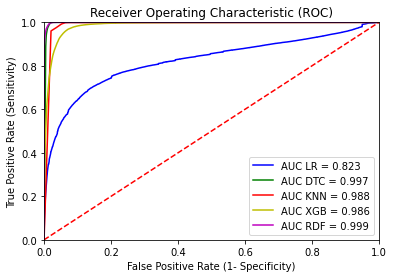

In [11]:
fpr_LR, tpr_LR, threshold_LR = metrics.roc_curve(y_test, preds_LR)
roc_auc_LR = metrics.auc(fpr_LR, tpr_LR)

fpr_DTC, tpr_DTC, threshold_DTC = metrics.roc_curve(y_test, preds_DTC)
roc_auc_DTC = metrics.auc(fpr_DTC, tpr_DTC)

fpr_KNN, tpr_KNN, threshold_KN = metrics.roc_curve(y_test, preds_KN)
roc_auc_KNN = metrics.auc(fpr_KNN, tpr_KNN)

fpr_XGB, tpr_XGB, threshold_XGB = metrics.roc_curve(y_test, preds_XGB)
roc_auc_XGB = metrics.auc(fpr_XGB, tpr_XGB)

fpr_RDF, tpr_RDF, threshold_RDF = metrics.roc_curve(y_test, preds_RDF)
roc_auc_RDF = metrics.auc(fpr_RDF, tpr_RDF)


plt.title('Receiver Operating Characteristic (ROC)')

plt.plot(fpr_LR, tpr_LR, 'b', label = 'AUC LR = %0.3f' % roc_auc_LR)
plt.plot(fpr_DTC, tpr_DTC, 'g', label = 'AUC DTC = %0.3f' % roc_auc_DTC)
plt.plot(fpr_KNN, tpr_KNN, 'r', label = 'AUC KNN = %0.3f' % roc_auc_KNN)
plt.plot(fpr_XGB, tpr_XGB, 'y', label = 'AUC XGB = %0.3f' % roc_auc_XGB)
plt.plot(fpr_RDF, tpr_RDF, 'm', label = 'AUC RDF = %0.3f' % roc_auc_RDF)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1- Specificity)')
plt.show()

**HYPERPARAMETER TUNING SU DECISION TREE**

In [12]:
dtc = DecisionTreeClassifier(random_state=1234)
 
param_grid = {
    'criterion': ['entropy','gini'],
    'max_depth': [40,50],
    'min_samples_split': [1,2],
    'min_samples_leaf': [1,2]
}

dtc_grid_search = GridSearchCV(estimator = dtc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

dtc_grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\dsalvatorelli\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.98829081        nan 0.98749525        nan 0.98831066
        nan 0.98750799        nan 0.98818837        nan 0.98723793
        nan 0.98819961        nan 0.98725685]
  warnings.warn(


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [40, 50], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [1, 2]},
             verbose=2)

In [13]:
dtc_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [64]:
dtc_tuned = DecisionTreeClassifier(criterion = 'entropy', max_depth=50, min_samples_split= 2)

In [65]:
y_1= ds_over['occupancy']
X_1 = ds_over.drop(['occupancy','room'], axis=1)

X_train,X_test, y_train, y_test = train_test_split(X_1,y_1,test_size=0.2,random_state=0)

In [66]:
dtc_tuned.fit(X_train,y_train)
Y_train_pred_dtc_tuned = dtc_tuned.predict(X_train)
Y_test_pred_dtc_tuned = dtc_tuned.predict(X_test)


print("Train Accuracy after optimization :",accuracy_score(y_train, Y_train_pred_dtc_tuned))
print("Test Accuracy after optimization :",accuracy_score(y_test, Y_test_pred_dtc_tuned))
print("Train F1 Score after optimization :",f1_score(y_train, Y_train_pred_dtc_tuned))
print("Test F1 Score after optimization :",f1_score(y_test, Y_test_pred_dtc_tuned))
print(confusion_matrix(y_test, Y_test_pred_dtc_tuned))
print(classification_report(y_test, Y_test_pred_dtc_tuned))

Train Accuracy after optimization : 0.9913466270835628
Test Accuracy after optimization : 0.989027757593373
Train F1 Score after optimization : 0.9914035156915699
Test F1 Score after optimization : 0.9891317494344012
[[653747  13352]
 [  1295 666520]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    667099
           1       0.98      1.00      0.99    667815

    accuracy                           0.99   1334914
   macro avg       0.99      0.99      0.99   1334914
weighted avg       0.99      0.99      0.99   1334914



**ASSESSMENT : ROC CURVE MODELLO MIGLIORE OTTIMIZZATO**

In [16]:
probs_dtc_tuned_train = dtc_tuned.predict_proba(X_train)
preds_dtc_tuned_train = probs_dtc_tuned_train[:,1]

probs_dtc_tuned_test = dtc_tuned.predict_proba(X_test)
preds_dtc_tuned_test = probs_dtc_tuned_test[:,1]

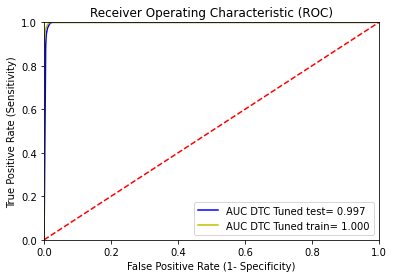

In [21]:
fpr_dtc_tuned_train, tpr_dtc_tuned_train, threshold_dtc_tuned_train = metrics.roc_curve(y_train, preds_dtc_tuned_train)
roc_auc_dtc_tuned_train = metrics.auc(fpr_dtc_tuned_train, tpr_dtc_tuned_train)

fpr_dtc_tuned_test, tpr_dtc_tuned_test, threshold_dtc_tuned_test = metrics.roc_curve(y_test, preds_dtc_tuned_test)
roc_auc_dtc_tuned_test = metrics.auc(fpr_dtc_tuned_test, tpr_dtc_tuned_test)

plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr_dtc_tuned_test, tpr_dtc_tuned_test, 'b', label = 'AUC DTC Tuned test= %0.3f' % roc_auc_dtc_tuned_test)
plt.plot(fpr_dtc_tuned_train, tpr_dtc_tuned_train, 'y', label = 'AUC DTC Tuned train= %0.3f' % roc_auc_dtc_tuned_train)


plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1- Specificity)')
plt.show()

**scelta soglia**

In [ ]:
Soglia = pd.DataFrame()

for threshold in np.arange(0,1,0.1):
    DT = DecisionTreeClassifier(random_state=0)
    start_time = time.time()
    DT.fit(X_train,y_train)
    y_pred_train_DT = DT.predict(X_train)
    y_pred_test_DT = DT.predict(X_test)
    predicted_proba_DT = DT.predict_proba(X_test)
    y_predicted_DT = (predicted_proba_DT [:,1] >= threshold).astype('int')
    acc_train_DT = accuracy_score(y_train,y_pred_train_DT)
    acc_test_DT = accuracy_score(y_test,y_predicted_DT)
    acc_test_three = accuracy_score(y_test,y_predicted_DT)
    f1_score_train_DT = f1_score(y_train, y_pred_train_DT)
    f1_score_test_DT = f1_score(y_test, y_pred_test_DT)
    precision_thre = precision_score(y_test,y_predicted_DT)
    recall_thre = recall_score(y_test,y_predicted_DT)
    timez_DT = (time.time() - start_time)

    df_DT = {"Classifier": "Decision Tree",'Train Accuracy': acc_train_DT, 'Test Accuracy': acc_test_DT, 'Train F1': f1_score_train_DT, 'Test F1': f1_score_test_DT, 'Training time [s]': timez_DT,
    'Predicted score': acc_test_three, 'threshold':threshold,'precision':precision_thre,'recall':recall_thre}
    Soglia = Soglia.append(df_DT, ignore_index=True)
Soglia.head()

In [22]:
dtc_tuned = DecisionTreeClassifier(criterion = 'entropy', max_depth=50, min_samples_split= 2)

plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(dtc_tuned.fit(X_train,y_train), fontsize=10)
plt.show()

KeyboardInterrupt: 

**Feature importance**

In [68]:
for importance, name in sorted(zip(dtc_tuned.feature_importances_, X_train.columns),reverse=True)[:5]:
    print (name, importance)

light 0.47818471852541383
co2 0.20620894240714588
temperature 0.16024520130565656
humidity 0.1553611377617837


Text(0.5, 0, 'Relative Importance')

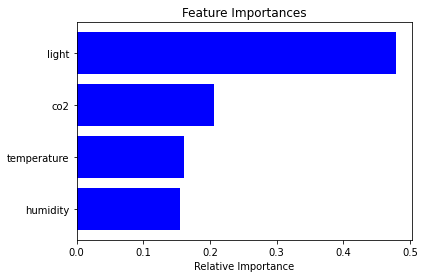

In [67]:
features = X_train.columns
importances = dtc_tuned.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

**Assessment per combinazione co2 - Occupancy**

In [53]:
y_1= ds_over['occupancy']
X_1 = ds_over.drop(['occupancy','light','temperature','humidity','room'], axis=1)

X_1_train,X_1_test, y_1_train, y_1_test = train_test_split(X_1,y_1,test_size=0.2,random_state=0)

In [54]:
dtc_tuned.fit(X_1_train,y_1_train)
Y_train_pred_1 = dtc_tuned.predict(X_1_train)
Y_test_pred_1 = dtc_tuned.predict(X_1_test)


print("Train Accuracy after optimization :",accuracy_score(y_1_train, Y_train_pred_1))
print("Test Accuracy after optimization :",accuracy_score(y_1_test, Y_test_pred_1))
print("Train F1 Score after optimization :",f1_score(y_1_train, Y_train_pred_1))
print("Test F1 Score after optimization :",f1_score(y_1_test, Y_test_pred_1))
print(confusion_matrix(y_1_test, Y_test_pred_1))
print(classification_report(y_1_test, Y_test_pred_1))

Train Accuracy after optimization : 0.7763917948210857
Test Accuracy after optimization : 0.7769466797112023
Train F1 Score after optimization : 0.7542156283939729
Test F1 Score after optimization : 0.7550605239237106
[[578218  88881]
 [208876 458939]]
              precision    recall  f1-score   support

           0       0.73      0.87      0.80    667099
           1       0.84      0.69      0.76    667815

    accuracy                           0.78   1334914
   macro avg       0.79      0.78      0.78   1334914
weighted avg       0.79      0.78      0.78   1334914



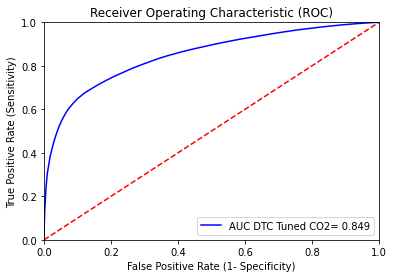

In [55]:
probs_dtc_tuned_CO2 = dtc_tuned.predict_proba(X_1_test)
preds_dtc_tuned_CO2 = probs_dtc_tuned_CO2[:,1]

fpr_dtc_tuned_CO2, tpr_dtc_tuned_CO2, threshold_dtc_tuned_CO2 = metrics.roc_curve(y_1_test, preds_dtc_tuned_CO2)
roc_auc_dtc_tuned_CO2 = metrics.auc(fpr_dtc_tuned_CO2, tpr_dtc_tuned_CO2)

plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr_dtc_tuned_CO2, tpr_dtc_tuned_CO2, 'b', label = 'AUC DTC Tuned CO2= %0.3f' % roc_auc_dtc_tuned_CO2)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1- Specificity)')
plt.show()

**Assessment per combinazione CO2/light - Occupancy**

In [59]:
y_2= ds_over['occupancy']
X_2 = ds_over.drop(['occupancy','temperature','humidity','room'], axis=1)

In [60]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size = 0.2, random_state = 1234)

dtc_tuned.fit(X_train_2,y_train_2)
Y_train_pred_2 = dtc_tuned.predict(X_train_2)
Y_test_pred_2 = dtc_tuned.predict(X_test_2)


print("Train Accuracy after optimization :",accuracy_score(y_train_2, Y_train_pred_2))
print("Test Accuracy after optimization :",accuracy_score(y_test_2, Y_test_pred_2))
print("Train F1 Score after optimization :",f1_score(y_train_2, Y_train_pred_2))
print("Test F1 Score after optimization :",f1_score(y_test_2, Y_test_pred_2))
print(confusion_matrix(y_test_2, Y_test_pred_2))
print(classification_report(y_test_2, Y_test_pred_2))

Train Accuracy after optimization : 0.9453569258820612
Test Accuracy after optimization : 0.9390260346359391
Train F1 Score after optimization : 0.9463496328827334
Test F1 Score after optimization : 0.9403514788831998
[[611928  55758]
 [ 25637 641591]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94    667686
           1       0.92      0.96      0.94    667228

    accuracy                           0.94   1334914
   macro avg       0.94      0.94      0.94   1334914
weighted avg       0.94      0.94      0.94   1334914



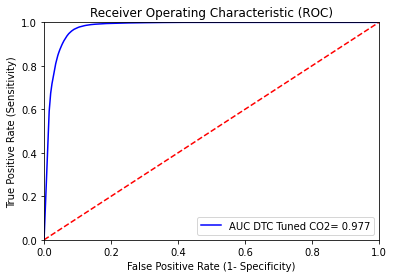

In [62]:
probs_dtc_tuned_CO2_light = dtc_tuned.predict_proba(X_test_2)
preds_dtc_tuned_CO2_light = probs_dtc_tuned_CO2_light[:,1]

fpr_dtc_tuned_CO2_light, tpr_dtc_tuned_CO2_light, threshold_dtc_tuned_CO2_light = metrics.roc_curve(y_test_2, preds_dtc_tuned_CO2_light)
roc_auc_dtc_tuned_CO2_light = metrics.auc(fpr_dtc_tuned_CO2_light, tpr_dtc_tuned_CO2_light)

plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr_dtc_tuned_CO2_light, tpr_dtc_tuned_CO2_light, 'b', label = 'AUC DTC Tuned CO2= %0.3f' % roc_auc_dtc_tuned_CO2_light)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1- Specificity)')
plt.show()